In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from utils.config import Config
from learner.dataset import FragmentDataset, DataCollator
from utils.parser import command_parser
from learner.model import Loss, Frag2Mol
import argparse
import pickle
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from learner.trainer import Trainer, save_ckpt
from torch.nn import functional as F
import matplotlib.pyplot as plt


/home/teddy_t/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config = pickle.load(open('RUNS/2022-07-15@11:41:09-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
vocab = pickle.load(open('RUNS/2022-07-15@11:41:09-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))

In [4]:
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
load_last = config.get('load_last')
trainer, epoch = Trainer.load(config, vocab, last=load_last)
data_sample, mu_stack = trainer.train(dataset.get_loader(), epoch + 1)

Vocab created/loaded. Size: 90175. Effective size: 90175. Time elapsed: 00:00:00.
loading best_loss.pt at epoch 9...
Data loaded. Size: 1090461. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


64
Epoch loss:  0.17289263010025024
len:  34077
Dataset: <class 'tuple'>
96
Epoch loss:  0.4078162908554077
len:  34077
Dataset: <class 'tuple'>
128
Epoch loss:  0.5805893093347549
len:  34077
Dataset: <class 'tuple'>
160
Epoch loss:  0.8800695985555649
len:  34077
Dataset: <class 'tuple'>
192
Epoch loss:  1.1888530403375626
len:  34077
Dataset: <class 'tuple'>
224
Epoch loss:  1.5157525092363358
len:  34077
Dataset: <class 'tuple'>
256
Epoch loss:  1.7229757755994797
len:  34077
Dataset: <class 'tuple'>
288
Epoch loss:  1.960098534822464
len:  34077
Dataset: <class 'tuple'>
320
Epoch loss:  2.160068765282631
len:  34077
Dataset: <class 'tuple'>
352
Epoch loss:  2.4088552743196487
len:  34077
Dataset: <class 'tuple'>
384
Epoch loss:  2.6935195177793503
len:  34077
Dataset: <class 'tuple'>
416
Epoch loss:  2.835120916366577
len:  34077
Dataset: <class 'tuple'>
448
Epoch loss:  3.150307983160019
len:  34077
Dataset: <class 'tuple'>
480
Epoch loss:  3.316389635205269
len:  34077
Dataset: 

Epoch loss:  27.242286764085293
len:  34077
Dataset: <class 'tuple'>
3680
Epoch loss:  27.445202223956585
len:  34077
Dataset: <class 'tuple'>
3712
Epoch loss:  27.634848915040493
len:  34077
Dataset: <class 'tuple'>
3744
Epoch loss:  27.973315499722958
len:  34077
Dataset: <class 'tuple'>
3776
Epoch loss:  28.1959111019969
len:  34077
Dataset: <class 'tuple'>
3808
Epoch loss:  28.423507653176785
len:  34077
Dataset: <class 'tuple'>
3840
Epoch loss:  28.612421549856663
len:  34077
Dataset: <class 'tuple'>
3872
Epoch loss:  28.821154482662678
len:  34077
Dataset: <class 'tuple'>
3904
Epoch loss:  28.984826751053333
len:  34077
Dataset: <class 'tuple'>
3936
Epoch loss:  29.151772387325764
len:  34077
Dataset: <class 'tuple'>
3968
Epoch loss:  29.343397699296474
len:  34077
Dataset: <class 'tuple'>
4000
Epoch loss:  29.46850637346506
len:  34077
Dataset: <class 'tuple'>
4032
Epoch loss:  29.56354756653309
len:  34077
Dataset: <class 'tuple'>
4064
Epoch loss:  29.809740766882896
len:  3407

Epoch loss:  52.68371531367302
len:  34077
Dataset: <class 'tuple'>
7264
Epoch loss:  52.899058654904366
len:  34077
Dataset: <class 'tuple'>
7296
Epoch loss:  53.12840047478676
len:  34077
Dataset: <class 'tuple'>
7328
Epoch loss:  53.31436009705067
len:  34077
Dataset: <class 'tuple'>
7360
Epoch loss:  53.513392210006714
len:  34077
Dataset: <class 'tuple'>
7392
Epoch loss:  53.79151776432991
len:  34077
Dataset: <class 'tuple'>
7424
Epoch loss:  53.979029819369316
len:  34077
Dataset: <class 'tuple'>
7456
Epoch loss:  54.23101417720318
len:  34077
Dataset: <class 'tuple'>
7488
Epoch loss:  54.40046267211437
len:  34077
Dataset: <class 'tuple'>
7520
Epoch loss:  54.61808027327061
len:  34077
Dataset: <class 'tuple'>
7552
Epoch loss:  54.90964566171169
len:  34077
Dataset: <class 'tuple'>
7584
Epoch loss:  55.24100239574909
len:  34077
Dataset: <class 'tuple'>
7616
Epoch loss:  55.4862712174654
len:  34077
Dataset: <class 'tuple'>
7648
Epoch loss:  55.6717010140419
len:  34077
Dataset

In [7]:
data_sample_index = [item for sublist in data_sample for item in sublist]

In [16]:
dataset.data.iloc[data_sample_index].logP.to_numpy()

array([3.92612, 4.1662 , 1.0295 , ..., 3.11182, 3.7222 , 4.64287])

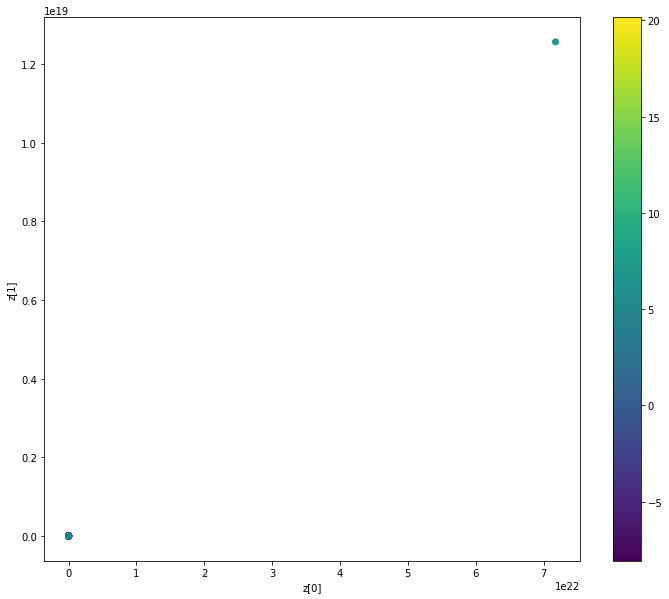

In [43]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:9984, 0].detach().numpy(), mu_stack[:9984, 1].detach().numpy(), c=dataset.data.iloc[data_sample_index].logP.to_numpy())
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0008, 0.0008)
#plt.ylim(-0.0009, 0.0009)
plt.show()

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x = mu_stack[:9984].detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'])

In [41]:
principalDf

,pc1,pc2,pc3
0,-0.077090,-0.050692,0.017952
1,-0.077132,-0.052495,0.017956
2,-0.077131,-0.052482,0.017941
3,-0.077131,-0.052482,0.017957
4,-0.077131,-0.052482,0.017955
...,...,...,...
9979,-0.077164,-0.052512,-0.798874
9980,-0.077159,-0.052507,-0.748614
9981,-0.077160,-0.052508,-0.803975
9982,-0.077160,-0.052508,-0.865643


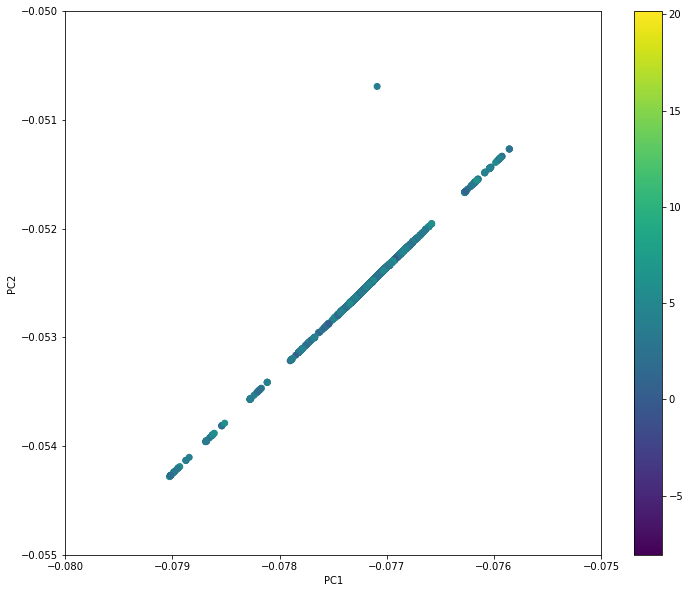

In [42]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            c=dataset.data.iloc[data_sample_index].logP.to_numpy())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.xlim(-0.08, -0.075)
plt.ylim(-0.055, -0.05)
plt.show()

In [44]:
def get_optimizer(config, model):
    return Adam(model.parameters(), lr=config.get('optim_lr'))


def get_scheduler(config, optimizer):
    return StepLR(optimizer,
                  step_size=config.get('sched_step_size'),
                  gamma=config.get('sched_gamma'))

In [94]:
model = Frag2Mol(config, vocab)
optimizer = get_optimizer(config, model)
scheduler = get_scheduler(config, optimizer)
criterion = Loss(config, pad=vocab.PAD)
model = model.cuda()
losses = []
best_loss = np.float('inf')
scores = []
best_score = - np.float('inf')

<ipython-input-94-1785cb37f18f>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_loss = np.float('inf')
<ipython-input-94-1785cb37f18f>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_score = - np.float('inf')


In [48]:
model

Frag2Mol(
  (embedder): Embedding(90175, 64)
  (latent2rnn): Linear(in_features=100, out_features=64, bias=True)
  (encoder): Encoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=128, out_features=100, bias=True)
    (rnn2logv): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=64, out_features=90175, bias=True)
  )
)

In [54]:
batch = next(iter(dataset.get_loader()))[0:3]

Data loaded. Size: 1090461. Time elapsed: 00:00:00.


In [95]:
device = torch.device('cpu')
src = batch[0].to(device)
tgt = batch[1]
lengths = batch[2]

In [96]:
device

device(type='cpu')

In [97]:
model = model.to(device)

In [100]:
yhat = model(Variable(src), lengths)

In [104]:
!pip install torchviz

In [106]:
from torchviz import make_dot

make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [ ]:
batch = next(iter(dataloader_train))
yhat = model(batch.text) # Give dummy batch to forward().

In [12]:
input_size = vocab.get_size()
embed_size = config.get('embed_size')
hidden_size = config.get('hidden_size')
hidden_layers = config.get('hidden_layers')
latent_size = config.get('latent_size')
dropout = config.get('dropout')
use_gpu = config.get('use_gpu')
embeddings = model.load_embeddings()
embedder = nn.Embedding.from_pretrained(embeddings)

latent2rnn = nn.Linear(
    in_features=latent_size,
    out_features=hidden_size)

encoder = Encoder(
    input_size=input_size,
    embed_size=embed_size,
    hidden_size=hidden_size,
    hidden_layers=hidden_layers,
    latent_size=self.latent_size,
    dropout=self.dropout,
    use_gpu=self.use_gpu)

self.decoder = Decoder(
    embed_size=self.embed_size,
    latent_size=self.latent_size,
    hidden_size=self.hidden_size,
    hidden_layers=self.hidden_layers,
    dropout=self.dropout,
    output_size=self.input_size)

In [8]:
dataset = FragmentDataset(config)

In [69]:
loader = dataset.get_loader()

Data loaded. Size: 1090461. Time elapsed: 00:00:00.


In [153]:
dataset.vocab = dataset.get_vocab()
collator = DataCollator(dataset.vocab)

Vocab created/loaded. Size: 90175. Effective size: 90175. Time elapsed: 00:00:00.


<ipython-input-10-1785cb37f18f>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_loss = np.float('inf')
<ipython-input-10-1785cb37f18f>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_score = - np.float('inf')


In [161]:
scheduler.step()
for idx, (src, tgt, lengths) in enumerate(loader):
    optimizer.zero_grad()

    src, tgt = Variable(src), Variable(tgt)
    print(src)
    print(tgt)

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 408988

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py", line 3505, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3623, in get_loc
    raise KeyError(key) from err
KeyError: 408988


In [152]:
loader = DataLoader(dataset=dataset.data,
                    collate_fn=collator,
                    batch_size=config.get('batch_size'),
                    num_workers=24,
                    shuffle=True)

In [4]:
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
trainer = Trainer(config, vocab)
trainer.train(dataset.get_loader(), 0)

Vocab created/loaded. Size: 90175. Effective size: 90175. Time elapsed: 00:00:00.
Data loaded. Size: 1090461. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32, 100])
torch.Size

KeyboardInterrupt: 

In [40]:
trainer = Trainer(config, vocab)

In [5]:
embeddings = model.load_embeddings()

NameError: name 'model' is not defined

In [150]:
embeddings.size()

torch.Size([90175, 64])

In [147]:
for index in range(2):
    seq = dataset.data.fragments[index].split(" ")
    seq = vocab.append_delimiters(seq)
    src = vocab.translate(seq[:-1])
    tgt = vocab.translate(seq[1:])
    lengths = len(seq)
    print(seq)
    print(src)
    print(tgt)
    print(lengths)
    src, tgt = Variable(torch.Tensor(src)), Variable(torch.Tensor(tgt))
    src = src.cuda()
    print(src)
    #output, mu, sigma = model(src, lengths)
    #embeddings = model.embedder(src)
    #print(embeddings)

['<SOS>', '*CCC', '*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O', '<EOS>']
[1, 11, 3]
[11, 3, 2]
4
tensor([ 1., 11.,  3.], device='cuda:0')
['<SOS>', '*c1ccc(O)cc1', '*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1', '<EOS>']
[1, 48, 4]
[48, 4, 2]
4
tensor([ 1., 48.,  4.], device='cuda:0')


In [ ]:
embeddings1 = F.dropout(embeddings, p=model.dropout, training=model.training)
z, mu, sigma = model.encoder(src, embeddings1, lengths)

In [43]:
trainer.train(dataset.get_loader(), 0)

Data loaded. Size: 1090461. Time elapsed: 00:00:00.


AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/teddy_t/UCL/drug_discovery/models/fragment-based-dgm/learner/dataset.py", line 51, in __getitem__
    seq = self.vocab.append_delimiters(seq)
AttributeError: 'NoneType' object has no attribute 'append_delimiters'


In [42]:
trainer._train_epoch(1, loader)

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/teddy_t/UCL/drug_discovery/models/fragment-based-dgm/learner/dataset.py", line 51, in __getitem__
    seq = self.vocab.append_delimiters(seq)
AttributeError: 'NoneType' object has no attribute 'append_delimiters'


In [34]:
for idx, (src, tgt, lengths) in enumerate(dataset.get_loader()):
    optimizer.zero_grad()

Data loaded. Size: 1090461. Time elapsed: 00:00:00.


AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/teddy_t/UCL/drug_discovery/models/fragment-based-dgm/learner/dataset.py", line 51, in __getitem__
    seq = self.vocab.append_delimiters(seq)
AttributeError: 'NoneType' object has no attribute 'append_delimiters'


In [10]:
model = torch.load('../RUNS/2022-07-15@11:41:09-LAPTOP-E1483HNR-CHEMBL/ckpt/last.pt')

In [11]:
model

{'epoch': 8,
 'best_loss': 0.2500355492672882,
 'losses': [51.92073293764322,
  0.45190641643213764,
  0.3796204249695559,
  0.33542668754950683,
  0.3045919733856347,
  0.2819181991444859,
  0.2643410344735349,
  0.2500355492672882,
  0.23796934265875444],
 'best_score': -inf,
 'scores': [],
 'model': OrderedDict([('embedder.weight',
               tensor([[-0.0125,  0.0451,  0.0232,  ..., -0.0229,  0.0329, -0.0143],
                       [-0.0219,  0.0043, -0.0359,  ..., -0.0073,  0.0318,  0.0361],
                       [-0.0493,  0.0011, -0.0083,  ..., -0.0258, -0.0407,  0.0397],
                       ...,
                       [ 0.0182,  0.0190,  0.0054,  ..., -0.0178, -0.0505, -0.1049],
                       [-0.1286,  0.0624,  0.1299,  ..., -0.1102, -0.0515, -0.1588],
                       [-0.0677,  0.0685,  0.0446,  ..., -0.0077, -0.0451, -0.1195]],
                      device='cuda:0')),
              ('latent2rnn.weight',
               tensor([[ 0.1167,  0.1656, -0.13